# Categorical Boost
#### cv score :  0.5623062381852553 (5 folds)

In [31]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings
warnings.filterwarnings('ignore')

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
from catboost import Pool, CatBoostClassifier, CatBoost
import matplotlib.pyplot as plt
import seaborn as sns


FEATURE_SELECTION = False
tgt_encode = False

random.seed(0)

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

%matplotlib inline

In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 304)
(28340, 303)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [4]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [5]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

# num_cols = ["level", "range", "rapid", "atack", "ink-sub", "fav-main", "good-special"]

num_cols = [
    "level", "range-main", "range-bullet-main", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "damage_max-special", 
    "duration-special", "good-special", "direct_rad-special", "distant_rad-special"
]

cols = [col for col in train_df.columns if "A1" in col or "A2" in col or "A3" in col or "A4" in col or 
        "B1" in col or "B2" in col or "B3" in col or "B4" in col]
drop_cols = []
for col1 in cols:
    f = True
    for col2 in num_cols:
        if col2 in col1:
            f = False
    if f and train_df[col1].dtype in [int, float]:
        drop_cols.append(col1)
        
#train_df = train_df.drop(columns=drop_cols)
#test_df = test_df.drop(columns=drop_cols)
        
    

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)



# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [6]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [7]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング

In [8]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)


#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
print("mizumashi")
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank、単体で意味なし
train_df, test_df = prepro.match_rank(train_df, test_df)

# rankを二列に分ける
train_df, test_df = prepro.ranker(train_df, test_df)




reskin
mainweapon
subweapon
special
mizumashi


In [12]:
# add team info、メインはなくてもいい

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])
#train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2"])

(160590, 765)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 863)
complete


In [13]:
# categorize team , 良い

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
#categorize_col = ["category1", "category2", "subweapon", "special"]
for col in categorize_col:
    print(col)
    train_df, test_df = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [14]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "match_rank")


train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A4")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B4")

In [15]:
# make input

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=False, scaler=False, verbose=False)

categorical_features_indices = np.where(X.dtypes == "object")[0]

complete


# 学習

In [19]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5
cat_tgtenc_cols = [
    "team-category1-A", "team-category1-B", "team-category2-A", "team-category2-B",
    "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"
]
cat_tgtenc_cols = []

#folds = prepro.make_stratified_kfolds(X, y, K, shuffle=True)
folds = prepro.make_stratified_kfolds(X, X["mode"].astype(str) + y.astype(str), K, shuffle=True, random_state=random.randint(0, 10000))


print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")
    
params = {
    "loss_function" : "Logloss",
    "eval_metric" : "Logloss",
    "iterations":2000,
    "learning_rate" : 0.05,
    "use_best_model": True,
    "random_seed":1,

    

}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
valid_ys = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    

    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
    
    
    
    
    train_data = Pool(train_X, train_y, cat_features=categorical_features_indices)
    valid_data = Pool(valid_X, valid_y, cat_features=categorical_features_indices)
    
    model = CatBoostClassifier(**params)

    
    model.fit(
        train_data,
        eval_set=valid_data,
        early_stopping_rounds=50,
        verbose=100,
        use_best_model=True,
    )
    
    pred = model.predict(valid_X)
    # pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred) 
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split
======================== fold 1 ========================
0:	learn: 0.6927635	test: 0.6928271	best: 0.6928271 (0)	total: 1.11s	remaining: 36m 57s
100:	learn: 0.6808265	test: 0.6842783	best: 0.6842783 (100)	total: 1m 33s	remaining: 29m 22s
200:	learn: 0.6751294	test: 0.6814104	best: 0.6814104 (200)	total: 3m 31s	remaining: 31m 33s
300:	learn: 0.6689870	test: 0.6782354	best: 0.6782256 (299)	total: 5m 43s	remaining: 32m 20s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6775071829
bestIteration = 359

Shrink model to first 360 iterations.
======================== fold 2 ========================
0:	learn: 0.6927633	test: 0.6927751	best: 0.6927751 (0)	total: 1.34s	remaining: 44m 49s
100:	learn: 0.6809380	test: 0.6837527	best: 0.6837527 (100)	total: 2m 7s	remaining: 39m 51s
200:	learn: 0.6753342	test: 0.6811786	best: 0.6811786 (200)	

0.5121682464062535
0.5094964127182574
0.5131230897486478
0.5112959727113509
0.511449999526559
0.5115067442222138


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

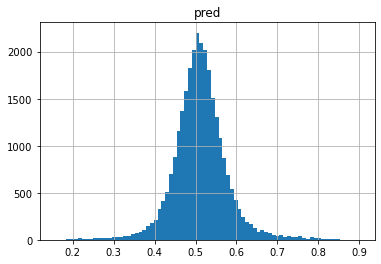

In [20]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X, prediction_type='Probability')[:,1]
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [21]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission_cat_5_{}.csv'.format(K))

0.5811926605504587


# モデル解釈

In [50]:
importance = pd.DataFrame(
    (models[0].get_feature_importance() + 
    models[1].get_feature_importance() + 
    models[2].get_feature_importance() + 
    models[3].get_feature_importance() + 
    models[4].get_feature_importance())/5
    , index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance[:120])

,importance
B-level-median,3.156927
A-level-median,3.054283
B-level-sum,1.591605
A-level-sum,1.492512
A-level-mean,1.476323
A-level-max,1.399727
B-level-mean,1.354830
A1-level,1.230401
B1-level,1.194584
B-level-max,1.142524


In [56]:
importance.tail(100)

,importance
B-ink-sub-median,0.005346
B-h3reelgun-mainweapon-onehot,0.005315
B-clashblaster-mainweapon-onehot,0.005252
B-parashelter-mainweapon-onehot,0.005252
A-splatspinner-mainweapon-onehot,0.004951
A-nicedama-special-onehot,0.004926
direct_rad-special-A3,0.004840
B-splatroller-mainweapon-onehot,0.004804
B-robotbomb_pitcher-special-onehot,0.004698
distant_rad-special-B3,0.004593


In [54]:
indices = [index for index in importance.index if "A2" in index]
importance.loc[indices]

,importance
mode x reskin-A2,1.087052
A2-rank-mark,0.506868
A2-level,0.402266
reskin-A2,0.259678
mainweapon-A2-count-by-mode,0.252983
reskin-A2-count-by-mode,0.201187
mainweapon-A2,0.185337
vote-main-A2,0.124935
fav-main-A2,0.115154
category1-A2,0.111798


In [28]:
train_df["pred"] = 0
train_df["y"] = y
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]
for mode in train_df["mode"].unique():
    rate = train_df[train_df["mode"] == mode][train_df["pred"] == train_df["y"]].shape[0] / train_df[train_df["mode"] == mode].shape[0]
    print("{} : {}".format(mode, rate))
print(train_df[train_df["pred"] == train_df["y"]].shape[0] / train_df.shape[0])

nawabari : 0.6139227360841872
hoko : 0.5488406330511594
yagura : 0.550924499229584
area : 0.5518538602318173
asari : 0.5473318537103156
0.5639017013232515


In [26]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [27]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

0.19338003259701078
0.21253944585081666
0.16267295488434996
0.22927142213128968
0.20213614453653292


In [ ]:
result_df[result_df["mode"] == "nawabari"]

In [20]:
preds

array([0.4339916 , 0.47415763, 0.50825852, ..., 0.54576242, 0.5183968 ,
       0.44101851])

In [51]:
def plot_feature_importance(importance,names,model_type, MAXSIZE=120):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:MAXSIZE]
    feature_names = np.array(names)[:MAXSIZE]

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,16))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

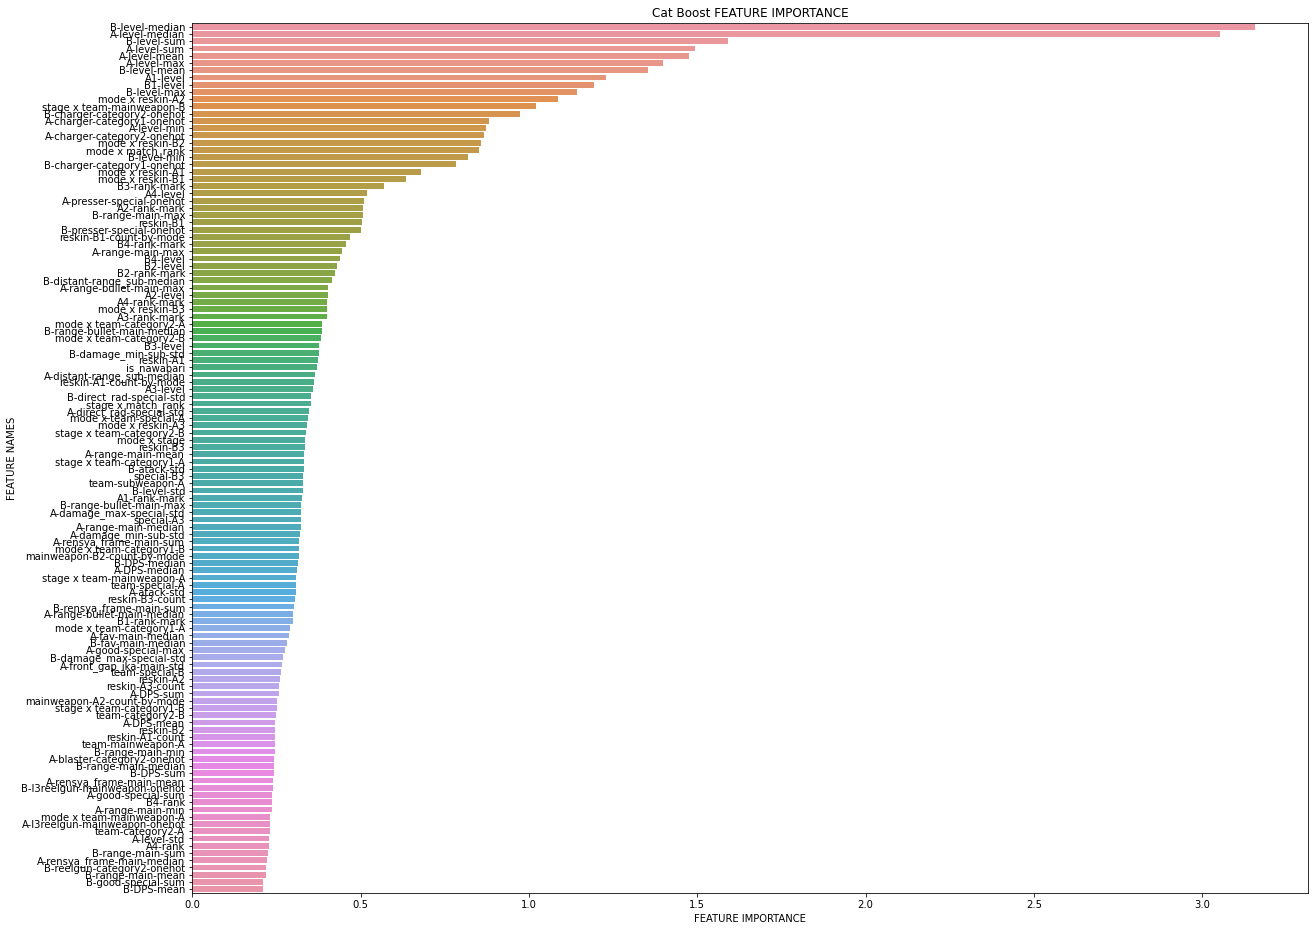

In [52]:
plot_feature_importance(importance.values.reshape(-1,), importance.index, "Cat Boost ")